In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk # natural language tool kit
import contractions
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
from nltk import pos_tag, word_tokenize   
import random
import re

from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [36]:
train = pd.read_csv('./train.tsv', sep='\t')
test = pd.read_csv('./test 2.tsv', sep = '\t')

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [37]:
# Remove grammar, tokenize, and lemmatize the sentences
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        # remove non-alphabetical characters
        text = re.sub('[^a-zA-Z]', ' ', sent)
        
        # tokenize sentence
        words = word_tokenize(text.lower())
        
        # remove stop words:
        new_words = [char for char in words if char.lower() not in stopwords.words('english')]
        
        # lemmatizing each word to its lemma
        lem = WordNetLemmatizer()
        lem_words = [lem.lemmatize(i) for i in new_words]
    
        reviews.append(lem_words)

    return(reviews)

In [38]:
train_sen = clean_sentences(train)
test_sen = clean_sentences(test)

100%|██████████| 66292/66292 [02:15<00:00, 488.96it/s]


In [39]:
print(len(train['Phrase']))
print(len(test['Phrase']))

156060
66292


In [40]:
print(len(train_sen))
print(len(test_sen))

156060
66292


In [41]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [42]:
target

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [43]:
X_train,X_val,y_train,y_val = train_test_split(train_sen,y_target,
                                             test_size=0.2,stratify=y_target)

In [44]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 682807.41it/s]

13618
30


In [45]:
vocab_size = len(list(unique_words))
embedding_dim = 300
max_length = len_max
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [46]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sen)


X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 30) (31212, 30) (66292, 30)


### Building a stack of layers with keras
* Embedding: Convert words of similar meanings to vector representation
* Conv1D: Applies a transformation
* Dropout: Randomly drops things to prevent overfitting
* Flatten: Change dimension of vector for dense
* Dense: Regular NN layer

In [47]:
from keras.models import Sequential
from keras.layers import Dense,Bidirectional,LSTM,Activation,Dropout,Flatten, Conv1D
from keras.layers.embeddings import Embedding


In [48]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length = max_length),
    Conv1D(128, 2, padding='same',activation='relu'),
    Dropout(0.2),
    Conv1D(64, 2, padding='same',activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(y_target.shape[1],activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

#### Stop training when the model has stopped improving!

In [49]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta = 0.001,
                               mode = 'max',
                               monitor = 'val_accuracy',
                               patience = 2)
callback = [early_stopping]

In [50]:
num_epochs = 9

history = model.fit(X_train,y_train,
                    validation_data = (X_val, y_val),
                    epochs = num_epochs,
                    batch_size = 256,
                    verbose = 1,
                    callbacks = callback)

Epoch 1/9
488/488 [==============================] - 56s 113ms/step - loss: 1.0364 - accuracy: 0.5828 - val_loss: 0.8691 - val_accuracy: 0.6439
Epoch 2/9
488/488 [==============================] - 54s 111ms/step - loss: 0.8018 - accuracy: 0.6716 - val_loss: 0.8226 - val_accuracy: 0.6642
Epoch 3/9
488/488 [==============================] - 54s 111ms/step - loss: 0.7146 - accuracy: 0.7007 - val_loss: 0.8237 - val_accuracy: 0.6671
Epoch 4/9
488/488 [==============================] - 57s 118ms/step - loss: 0.6595 - accuracy: 0.7209 - val_loss: 0.8474 - val_accuracy: 0.6591
Epoch 5/9
488/488 [==============================] - 54s 110ms/step - loss: 0.6173 - accuracy: 0.7345 - val_loss: 0.8789 - val_accuracy: 0.6598


In [51]:
y_pred = model.predict(X_val, verbose = 1)

976/976 [==============================] - 7s 7ms/step


In [52]:
y_pred

array([[4.39523283e-05, 7.26112770e-03, 9.55230832e-01, 3.70851159e-02,
        3.78943514e-04],
       [6.93250513e-06, 8.30957142e-04, 1.09859370e-01, 8.37535560e-01,
        5.17672151e-02],
       [4.85076249e-01, 4.12393838e-01, 9.56800506e-02, 6.23748638e-03,
        6.12383476e-04],
       ...,
       [5.87695524e-07, 4.21175908e-04, 9.76191044e-01, 2.33626924e-02,
        2.44649655e-05],
       [4.18484539e-01, 4.99355316e-01, 8.05331245e-02, 1.53805362e-03,
        8.88754075e-05],
       [1.02833934e-01, 7.78563499e-01, 1.15895368e-01, 2.69479956e-03,
        1.24426242e-05]], dtype=float32)

In [53]:
y_val

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [54]:
y_val_pred_max=[np.argmax(i) for i in y_pred]

In [55]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [56]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.34      0.50      0.41       960
           1       0.63      0.53      0.57      6470
           2       0.77      0.77      0.77     16035
           3       0.55      0.58      0.56      6249
           4       0.44      0.54      0.49      1498

    accuracy                           0.66     31212
   macro avg       0.55      0.58      0.56     31212
weighted avg       0.67      0.66      0.66     31212



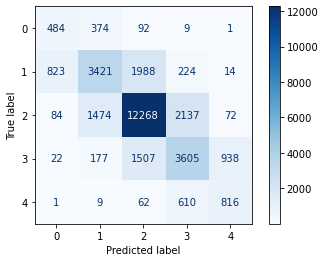

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)